# ML flow

In [112]:
pip install --upgrade mlflow

Note: you may need to restart the kernel to use updated packages.


## MLflow tracking: Setup new experiment

In [113]:
import mlflow
import mlflow.sklearn
import mlflow.pyfunc

# Set the MLflow tracking URI to the server where you want to track experiments
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Import Libraries

In [114]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor,BaseRRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from causalml.inference.meta import BaseXLearner, BaseSLearner, BaseTLearner, BaseRLearner
from causalml.inference.meta.explainer import Explainer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.pipeline import Pipeline
from flask import Flask, request, jsonify
import mlflow.sklearn
import pickle

# Import Data

In [115]:
df = pd.read_csv('/Users/qianlou/Documents/GitHub/Customer-Personality-Analysis-2.0/Data/Preprocessed Data/Final Preprocessed Data.csv')

# Causal Inference Pipeline

In [116]:
# Start an MLflow experiment
mlflow.set_experiment("Causal_Inference_Model_R")

<Experiment: artifact_location='mlflow-artifacts:/463242657249483073', creation_time=1714089828573, experiment_id='463242657249483073', last_update_time=1714089828573, lifecycle_stage='active', name='Causal_Inference_Model_R', tags={}>

In [117]:
def causal_inference_pipeline(df, X_cols, treatments):
    outcomes = ['Recency']
    results = []

    for outcome in outcomes:
        for treatment in treatments:
            with mlflow.start_run():
                # Log the treatment and outcome as parameters
                mlflow.log_param("Treatment", treatment)
                mlflow.log_param("Outcome", outcome)

                # Prepare covariates
                covariates = [col for col in X_cols if col != treatment and col != outcome]
                if outcome == 'Total_purchase':
                    covariates.remove('Total_amount')
                elif outcome == 'Total_amount':
                    covariates.remove('Total_purchase')
                X = df[covariates]
                y = df[outcome]
                t = df[treatment]

                # Split data into training and testing sets
                X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
                    X, y, t, test_size=0.2, random_state=42)

                lowest_rmse = float('inf')
                best_model = None
                best_ate = None
                best_shap_values = None

                # Iterate over model types
                for model_type in [XGBRegressor]:  
                    model = model_type()
                    model.fit(X_train, y_train)
                    shap_values = None
                    if hasattr(model, 'predict'):
                        explainer = shap.Explainer(model)
                        shap_values = explainer(X_test)

                    # Estimate ATE
                    ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                    # Predictions for MSE calculation
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                    if rmse < lowest_rmse:
                        lowest_rmse = rmse
                        best_model = model
                        best_ate = ate_mean
                        best_shap_values = shap_values

                # Save the best model and SHAP values if model is selected
                if best_model is not None:
                    model_path = f"{treatment}_{outcome}_model.pkl"
                    with open(model_path, 'wb') as f:
                        pickle.dump(best_model, f)
                    mlflow.log_artifact(model_path)

                    if best_shap_values is not None:
                        mlflow.log_metric("ATE", best_ate)
                        mlflow.log_metric("RMSE", lowest_rmse)
                        
                        # Save and log SHAP plots
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.summary_plot(best_shap_values, X_test, plot_type="bar")
                        plt.show()
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.plots.beeswarm(best_shap_values, max_display=20)
                        plt.show()
                        
                        # Save and log SHAP values
                        
                        shap_values_path = f"{treatment}_{outcome}_shap_values.pkl"
                        with open(shap_values_path, 'wb') as f:
                            pickle.dump(best_shap_values, f)
                        mlflow.log_artifact(shap_values_path)

                results.append({
                    'Outcome': outcome,
                    'Treatment': treatment,
                    'Model Type': best_model.__class__.__name__ if best_model else None,
                    'ATE': best_ate,
                    'RMSE': lowest_rmse
                })

    results_df = pd.DataFrame(results)
    return results_df

def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

[23:37:11] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


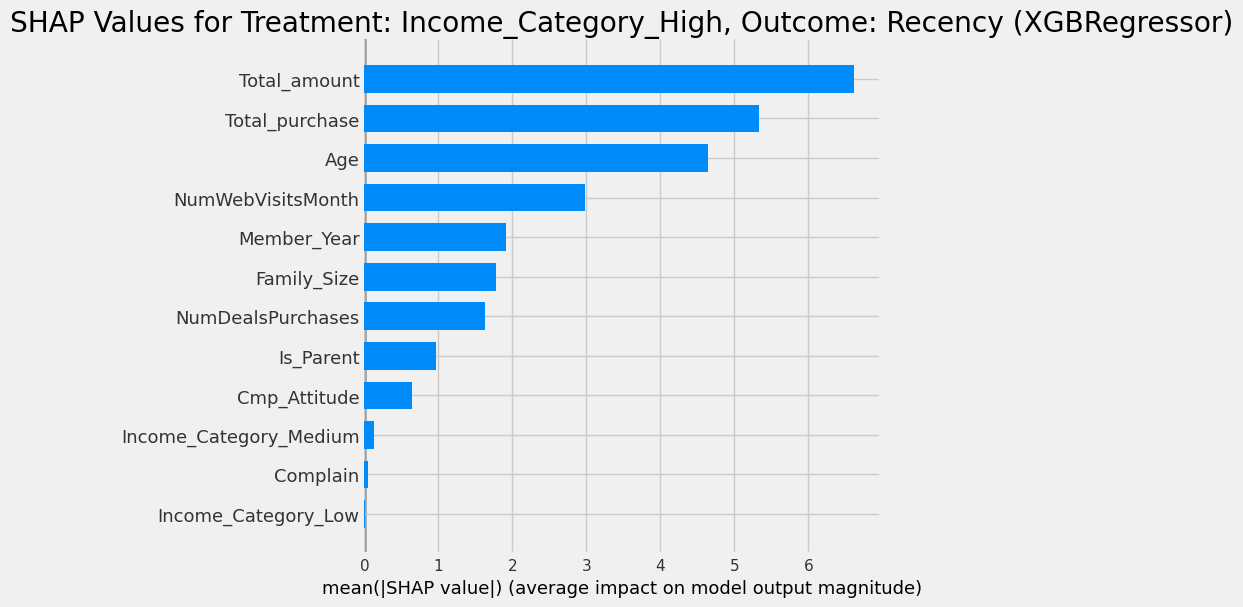

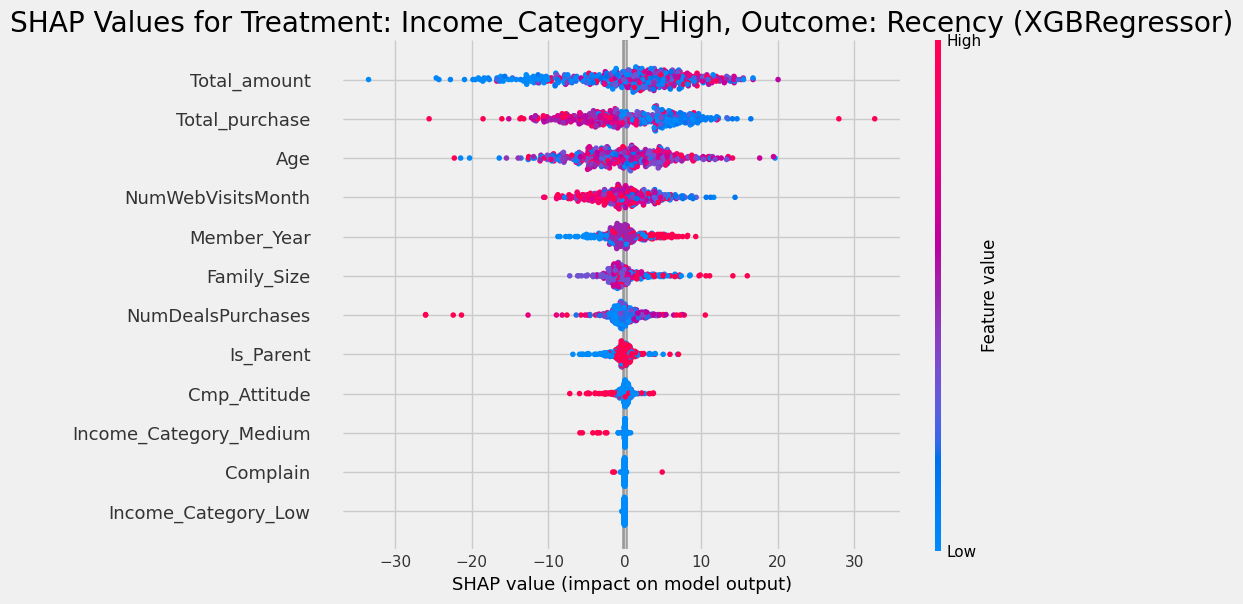

[23:37:12] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


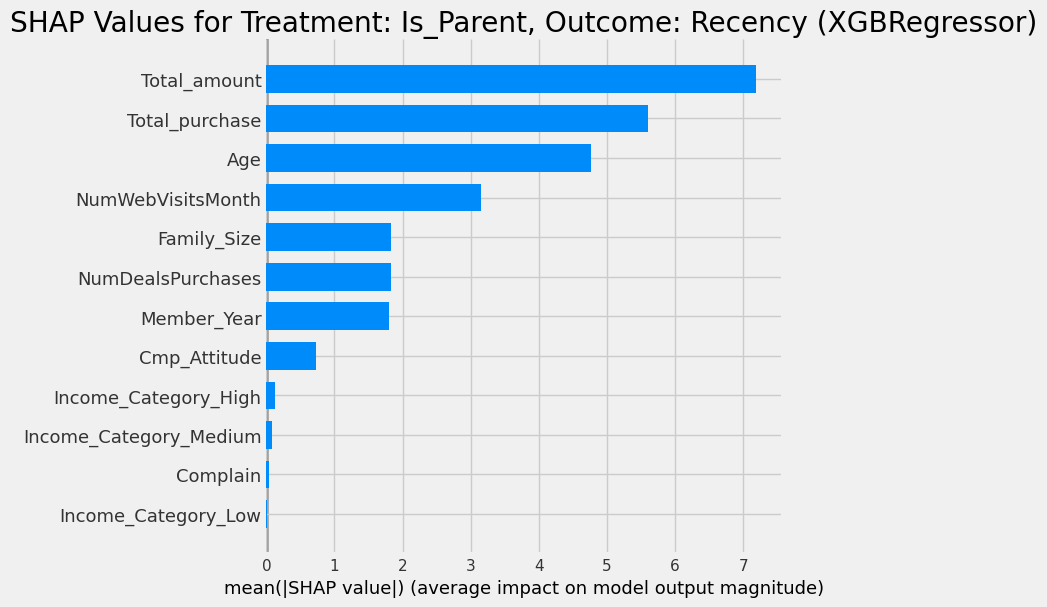

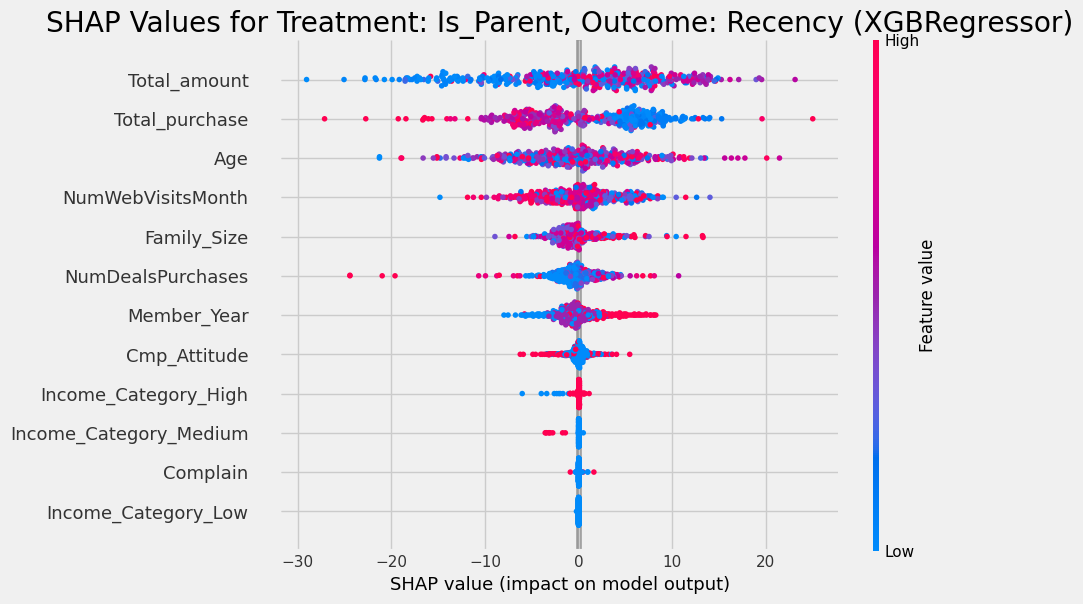

[23:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


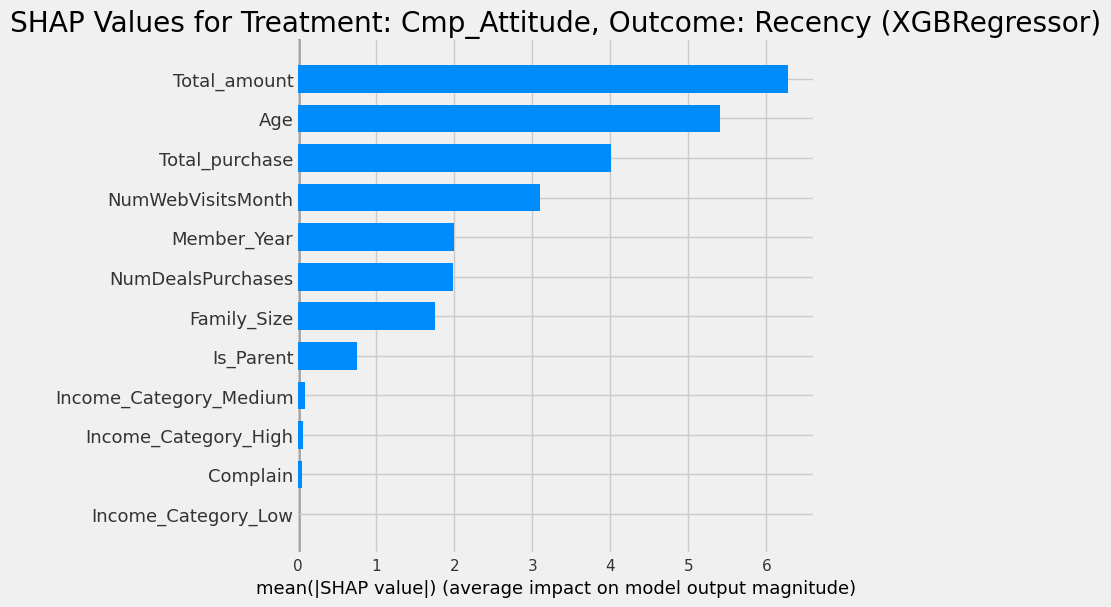

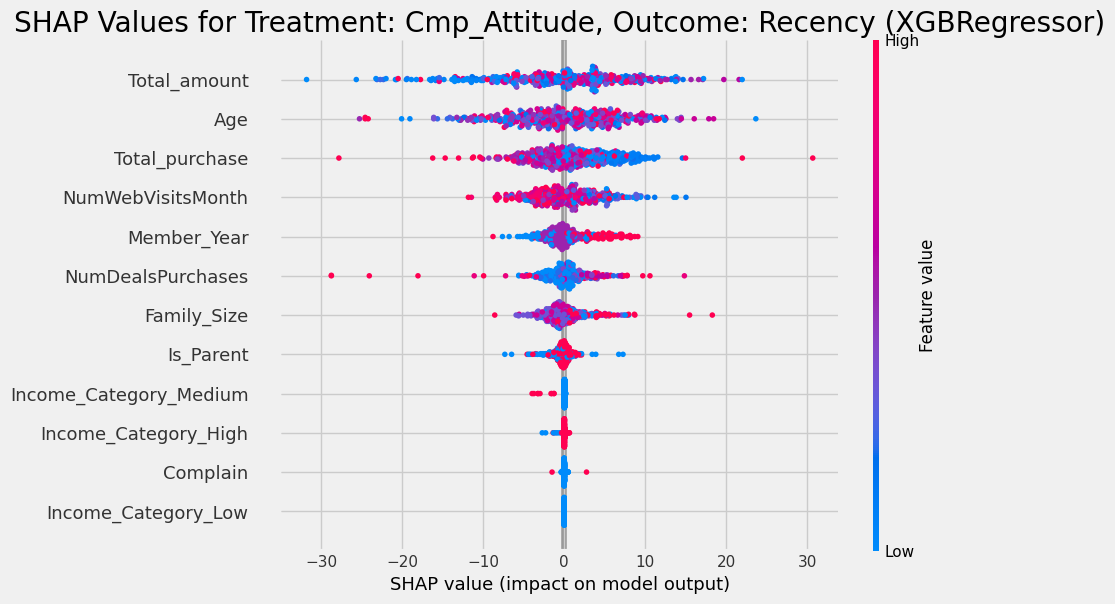

[23:37:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


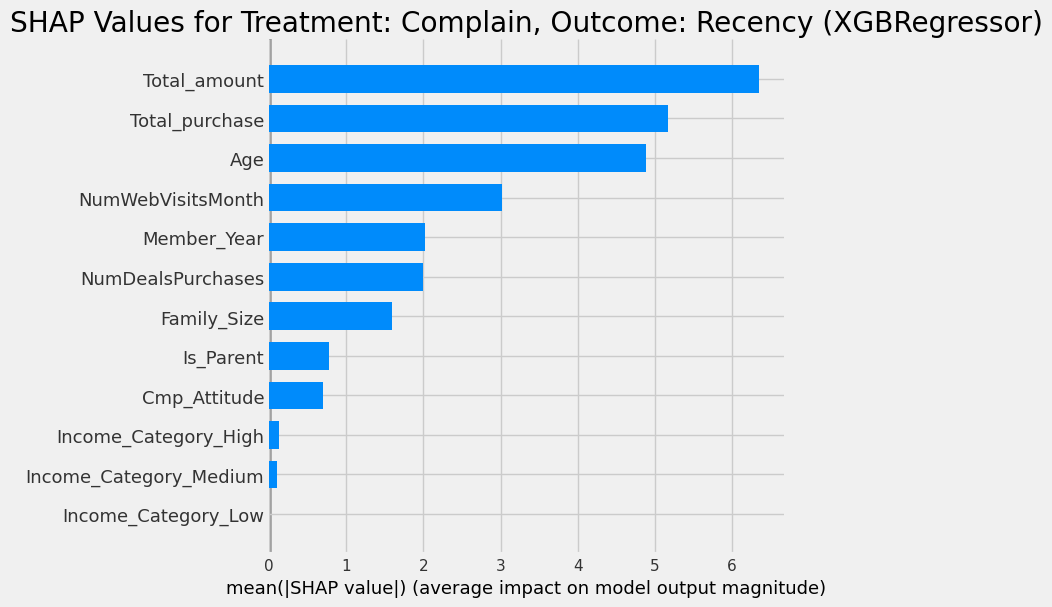

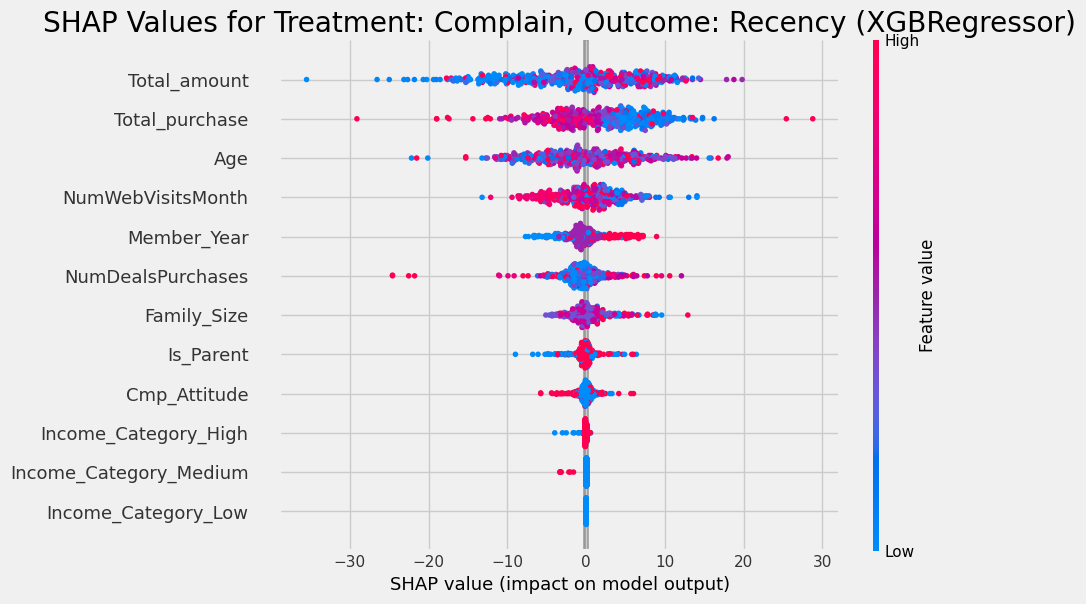

,Outcome,Treatment,Model Type,ATE,RMSE
0,Recency,Income_Category_High,XGBRegressor,0.984333,54.668270
1,Recency,Is_Parent,XGBRegressor,0.714969,54.865256
2,Recency,Cmp_Attitude,XGBRegressor,0.217046,55.342698
3,Recency,Complain,XGBRegressor,0.012355,55.493829


In [118]:
# Define treatments and covariates
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
                   'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
                   'Member_Year', 'Total_amount', 'Total_purchase',
                   'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']

# Run causal inference pipeline
results_df = causal_inference_pipeline(df, covariates_list, treatments)
results_df

In [119]:
# Start an MLflow experiment
mlflow.set_experiment("Causal_Inference_Model_F")

<Experiment: artifact_location='mlflow-artifacts:/341375771500513748', creation_time=1714089839502, experiment_id='341375771500513748', last_update_time=1714089839502, lifecycle_stage='active', name='Causal_Inference_Model_F', tags={}>

In [120]:
def causal_inference_pipeline(df, X_cols, treatments):
    outcomes = ['Total_purchase']
    results = []

    for outcome in outcomes:
        for treatment in treatments:
            with mlflow.start_run():
                # Log the treatment and outcome as parameters
                mlflow.log_param("Treatment", treatment)
                mlflow.log_param("Outcome", outcome)

                # Prepare covariates
                covariates = [col for col in X_cols if col != treatment and col != outcome]
                if outcome == 'Total_purchase':
                    covariates.remove('Total_amount')
                elif outcome == 'Total_amount':
                    covariates.remove('Total_purchase')
                X = df[covariates]
                y = df[outcome]
                t = df[treatment]

                # Split data into training and testing sets
                X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
                    X, y, t, test_size=0.2, random_state=42)

                lowest_rmse = float('inf')
                best_model = None
                best_ate = None
                best_shap_values = None

                # Iterate over model types
                for model_type in [XGBRegressor]:  
                    model = model_type()
                    model.fit(X_train, y_train)
                    shap_values = None
                    if hasattr(model, 'predict'):
                        explainer = shap.Explainer(model)
                        shap_values = explainer(X_test)

                    # Estimate ATE
                    ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                    # Predictions for MSE calculation
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                    if rmse < lowest_rmse:
                        lowest_rmse = rmse
                        best_model = model
                        best_ate = ate_mean
                        best_shap_values = shap_values

                # Save the best model and SHAP values if model is selected
                if best_model is not None:
                    model_path = f"{treatment}_{outcome}_model.pkl"
                    with open(model_path, 'wb') as f:
                        pickle.dump(best_model, f)
                    mlflow.log_artifact(model_path)

                    if best_shap_values is not None:
                        mlflow.log_metric("ATE", best_ate)
                        mlflow.log_metric("RMSE", lowest_rmse)
                        
                        # Save and log SHAP plots
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.summary_plot(best_shap_values, X_test, plot_type="bar")
                        plt.show()
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.plots.beeswarm(best_shap_values, max_display=20)
                        plt.show()
                        
                        # Save and log SHAP values
                        
                        shap_values_path = f"{treatment}_{outcome}_shap_values.pkl"
                        with open(shap_values_path, 'wb') as f:
                            pickle.dump(best_shap_values, f)
                        mlflow.log_artifact(shap_values_path)

                results.append({
                    'Outcome': outcome,
                    'Treatment': treatment,
                    'Model Type': best_model.__class__.__name__ if best_model else None,
                    'ATE': best_ate,
                    'RMSE': lowest_rmse
                })

    results_df = pd.DataFrame(results)
    return results_df

def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

[23:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


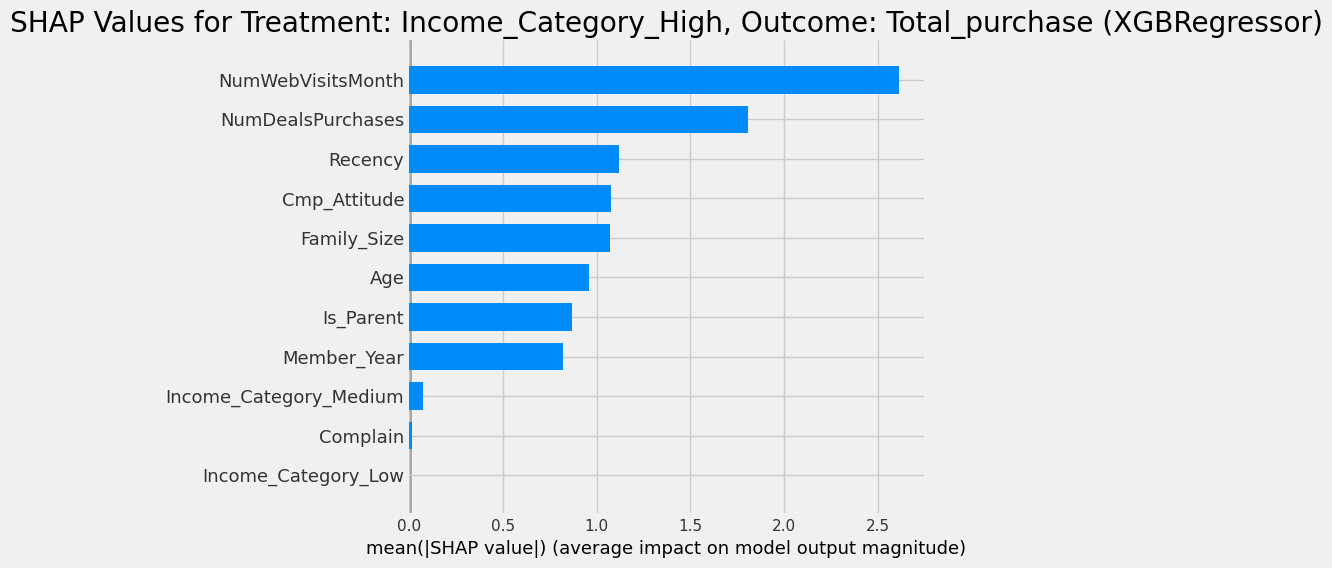

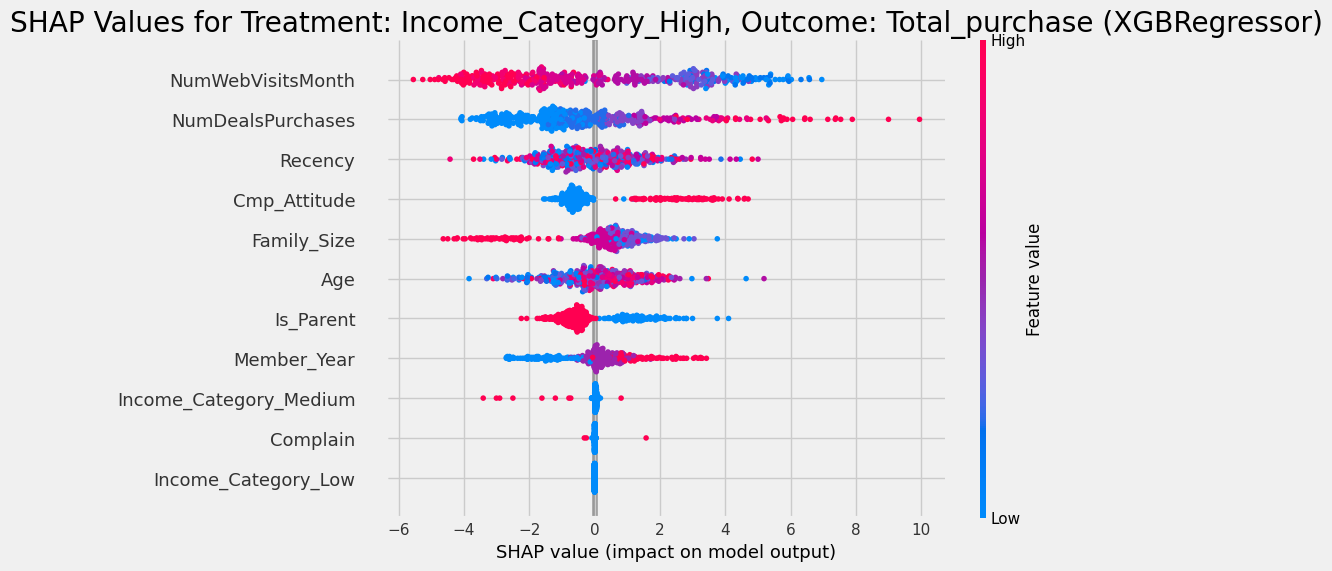

[23:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


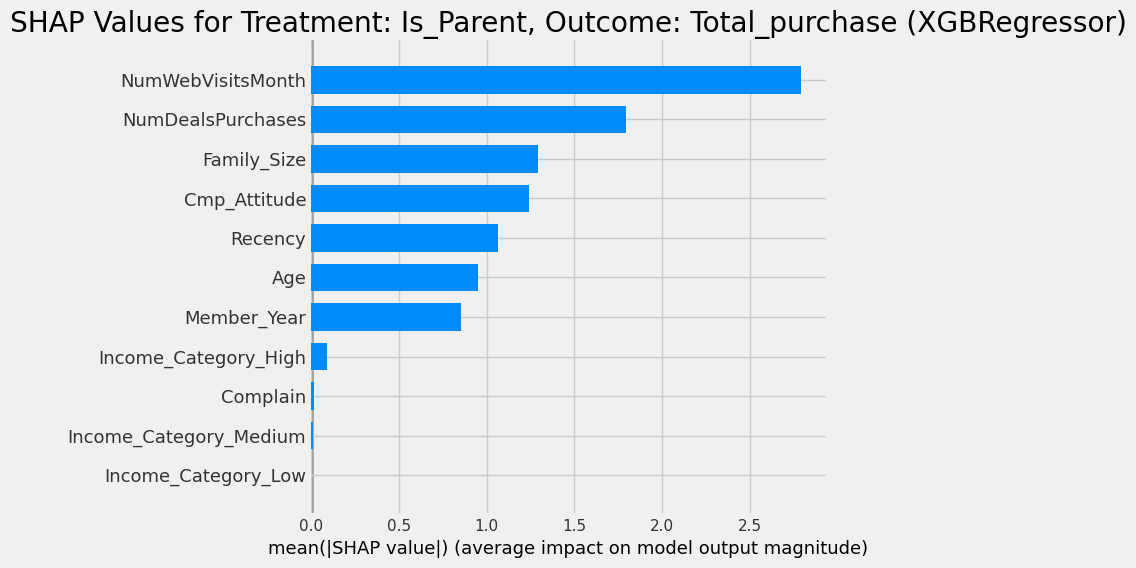

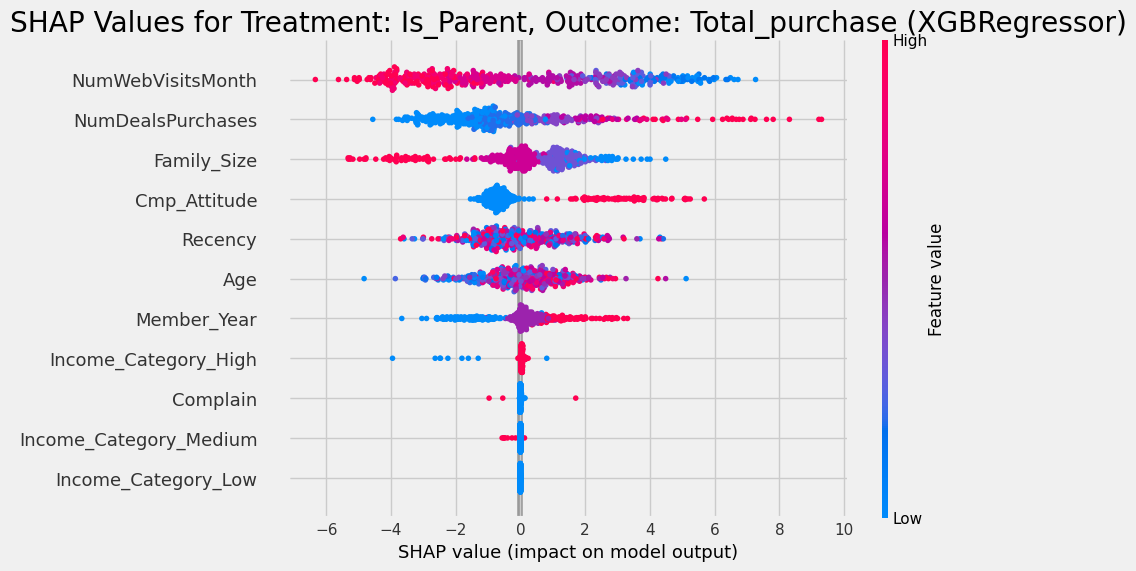

[23:37:18] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


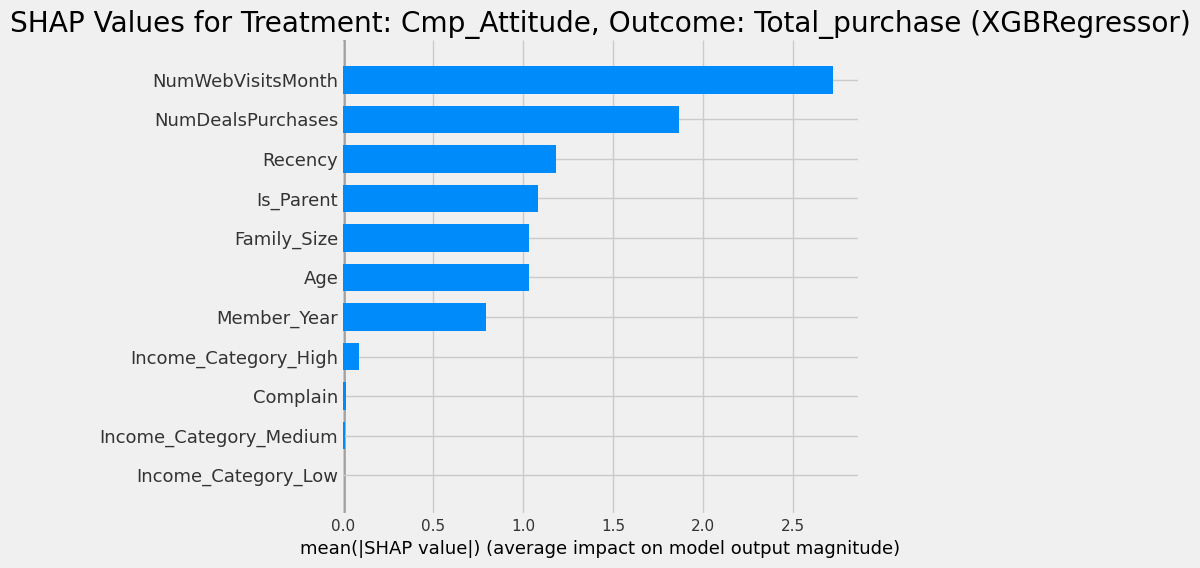

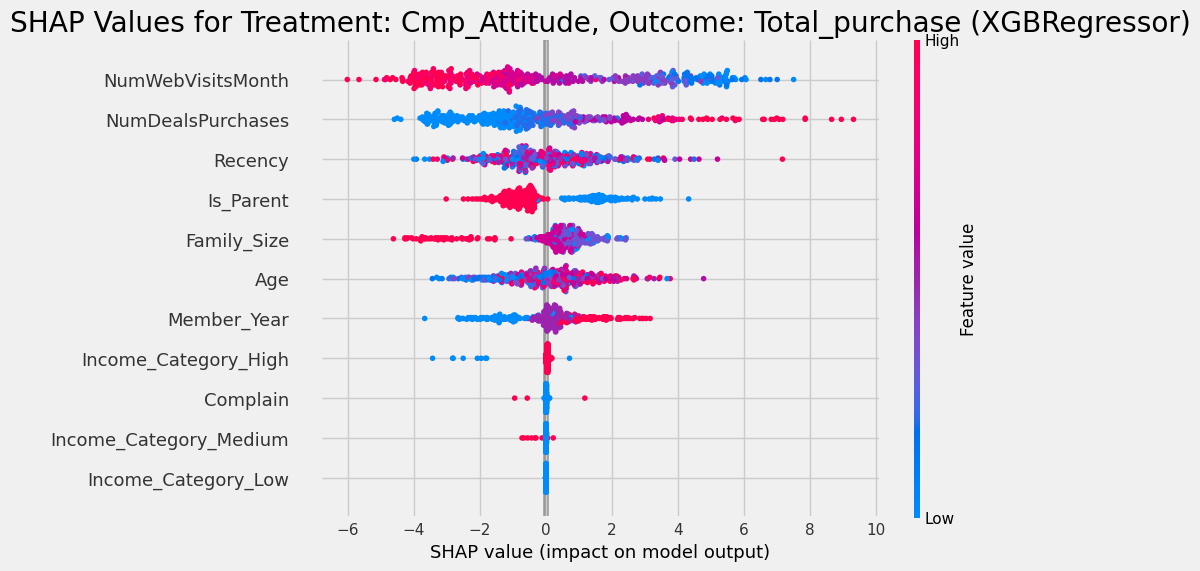

[23:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


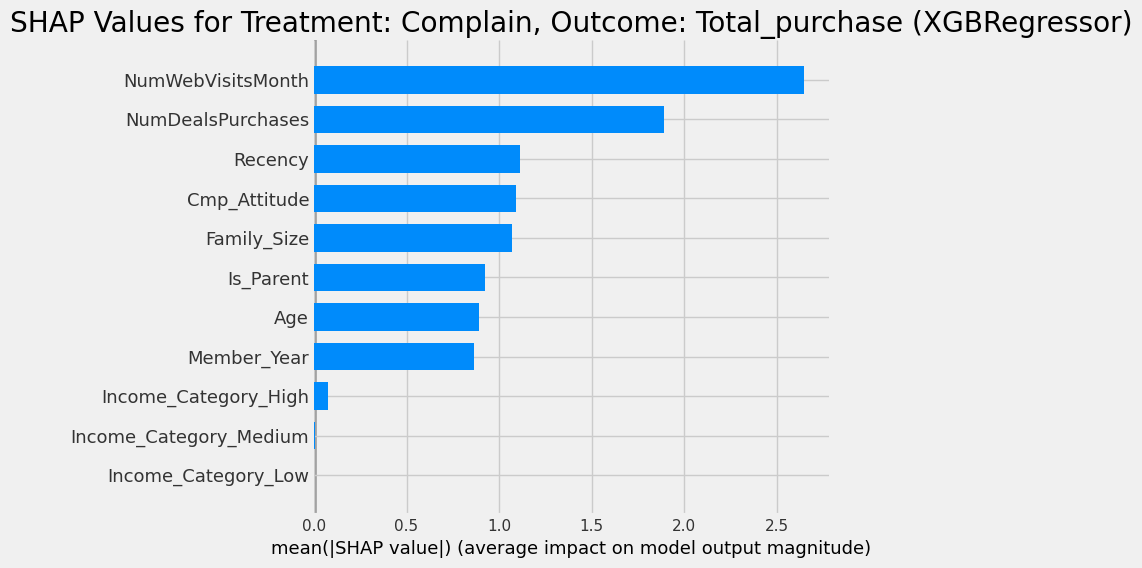

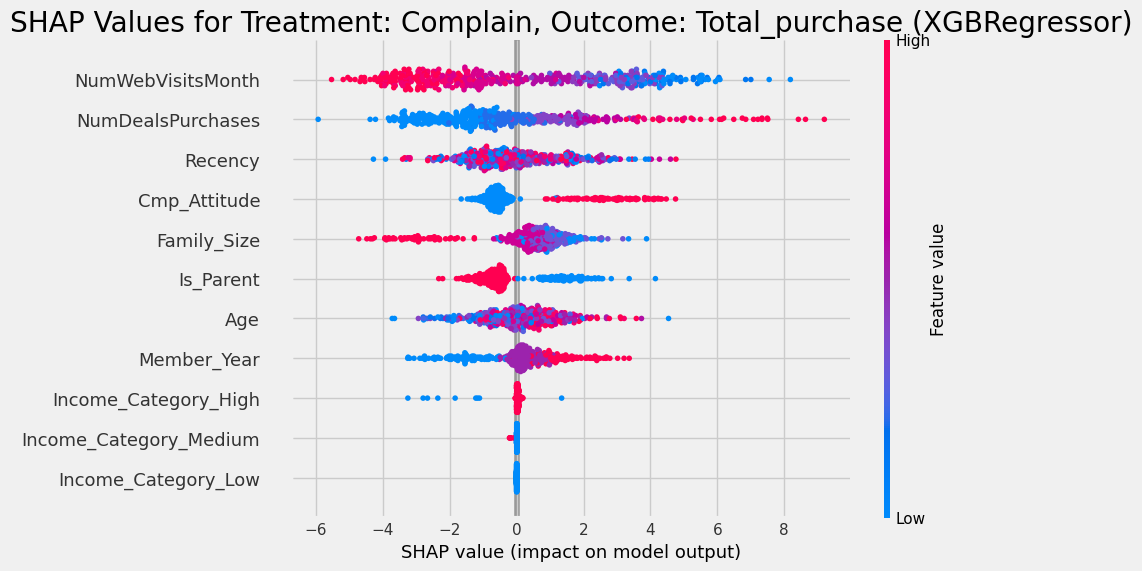

,Outcome,Treatment,Model Type,ATE,RMSE
0,Total_purchase,Income_Category_High,XGBRegressor,0.984334,13.986251
1,Total_purchase,Is_Parent,XGBRegressor,0.714974,14.285645
2,Total_purchase,Cmp_Attitude,XGBRegressor,0.223731,14.591813
3,Total_purchase,Complain,XGBRegressor,0.010959,14.830237


In [121]:
# Define treatments and covariates
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
                   'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
                   'Member_Year', 'Total_amount', 'Total_purchase',
                   'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']

# Run causal inference pipeline
results_df = causal_inference_pipeline(df, covariates_list, treatments)
results_df

In [122]:
# Start an MLflow experiment
mlflow.set_experiment("Causal_Inference_Model_M")

<Experiment: artifact_location='mlflow-artifacts:/434492188869788032', creation_time=1714089850702, experiment_id='434492188869788032', last_update_time=1714089850702, lifecycle_stage='active', name='Causal_Inference_Model_M', tags={}>

In [123]:
def causal_inference_pipeline(df, X_cols, treatments):
    outcomes = ['Total_amount']
    results = []

    for outcome in outcomes:
        for treatment in treatments:
            with mlflow.start_run():
                # Log the treatment and outcome as parameters
                mlflow.log_param("Treatment", treatment)
                mlflow.log_param("Outcome", outcome)

                # Prepare covariates
                covariates = [col for col in X_cols if col != treatment and col != outcome]
                if outcome == 'Total_purchase':
                    covariates.remove('Total_amount')
                elif outcome == 'Total_amount':
                    covariates.remove('Total_purchase')
                X = df[covariates]
                y = df[outcome]
                t = df[treatment]

                # Split data into training and testing sets
                X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
                    X, y, t, test_size=0.2, random_state=42)

                lowest_rmse = float('inf')
                best_model = None
                best_ate = None
                best_shap_values = None

                # Iterate over model types
                for model_type in [XGBRegressor]:  
                    model = model_type()
                    model.fit(X_train, y_train)
                    shap_values = None
                    if hasattr(model, 'predict'):
                        explainer = shap.Explainer(model)
                        shap_values = explainer(X_test)

                    # Estimate ATE
                    ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                    # Predictions for MSE calculation
                    y_pred = model.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                    if rmse < lowest_rmse:
                        lowest_rmse = rmse
                        best_model = model
                        best_ate = ate_mean
                        best_shap_values = shap_values

                # Save the best model and SHAP values if model is selected
                if best_model is not None:
                    model_path = f"{treatment}_{outcome}_model.pkl"
                    with open(model_path, 'wb') as f:
                        pickle.dump(best_model, f)
                    mlflow.log_artifact(model_path)

                    if best_shap_values is not None:
                        mlflow.log_metric("ATE", best_ate)
                        mlflow.log_metric("RMSE", lowest_rmse)
                        
                        # Save and log SHAP plots
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.summary_plot(best_shap_values, X_test, plot_type="bar")
                        plt.show()
                        plt.title(f'SHAP Values for Treatment: {treatment}, Outcome: {outcome} ({best_model.__class__.__name__})')
                        shap.plots.beeswarm(best_shap_values, max_display=20)
                        plt.show()
                        
                        # Save and log SHAP values
                        
                        shap_values_path = f"{treatment}_{outcome}_shap_values.pkl"
                        with open(shap_values_path, 'wb') as f:
                            pickle.dump(best_shap_values, f)
                        mlflow.log_artifact(shap_values_path)

                results.append({
                    'Outcome': outcome,
                    'Treatment': treatment,
                    'Model Type': best_model.__class__.__name__ if best_model else None,
                    'ATE': best_ate,
                    'RMSE': lowest_rmse
                })

    results_df = pd.DataFrame(results)
    return results_df

def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

[23:37:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


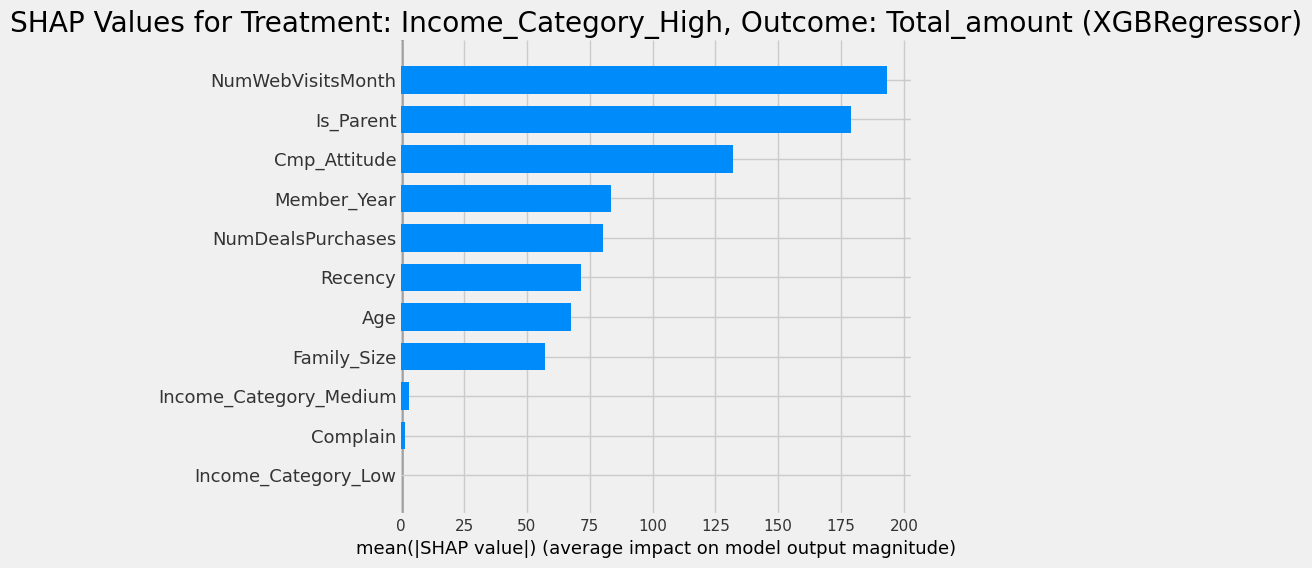

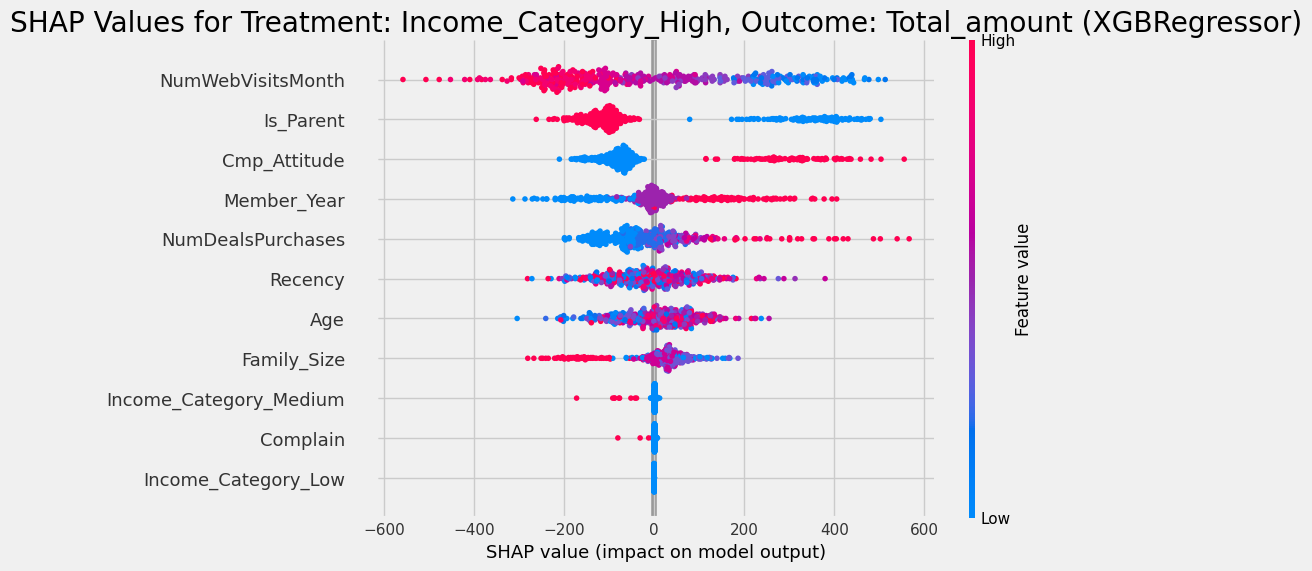

[23:37:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


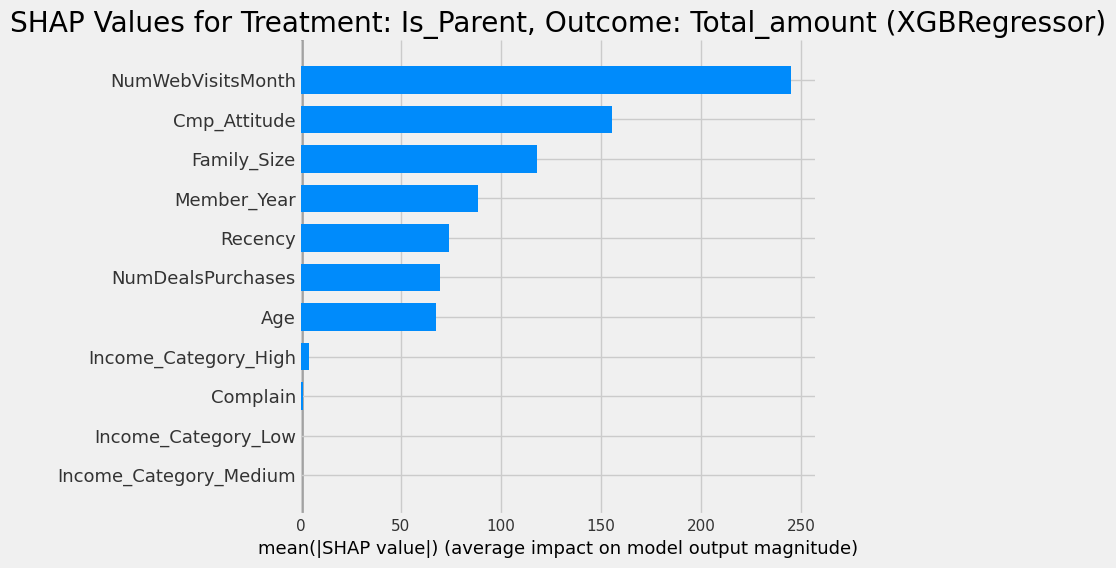

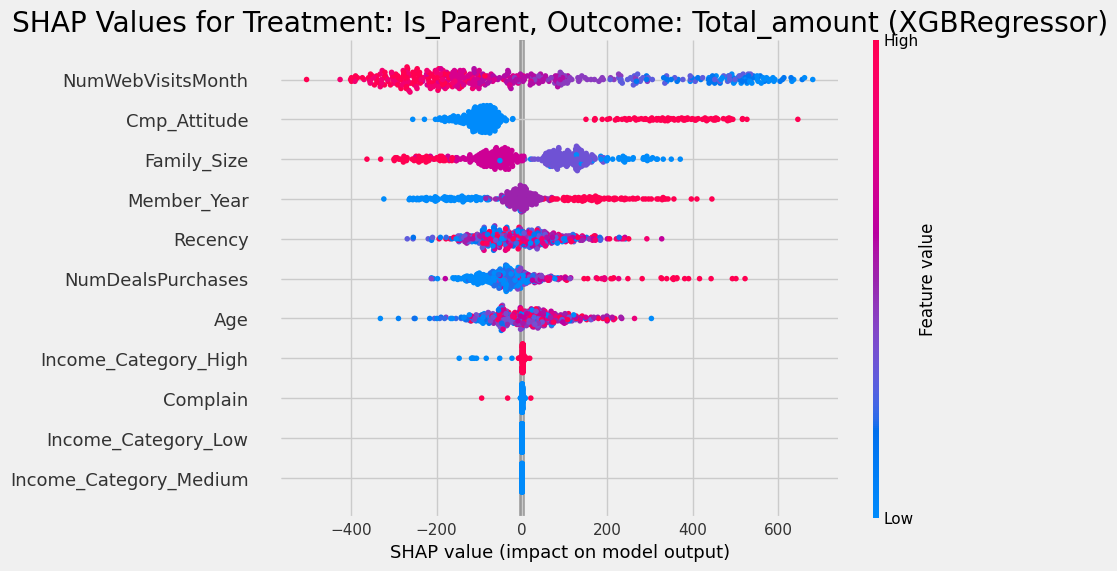

[23:37:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[23:37:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


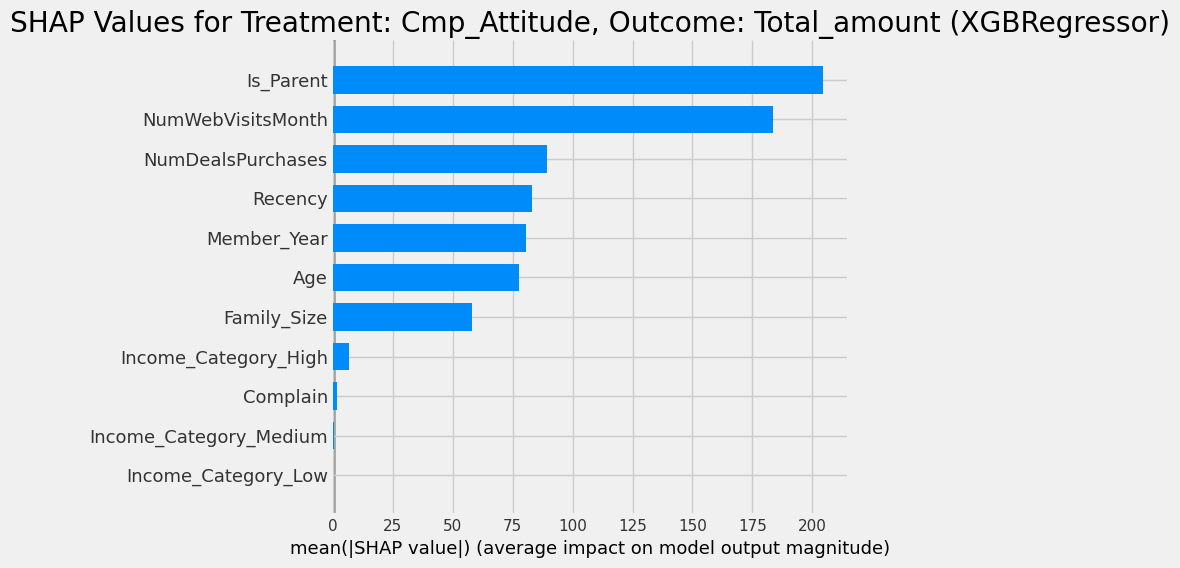

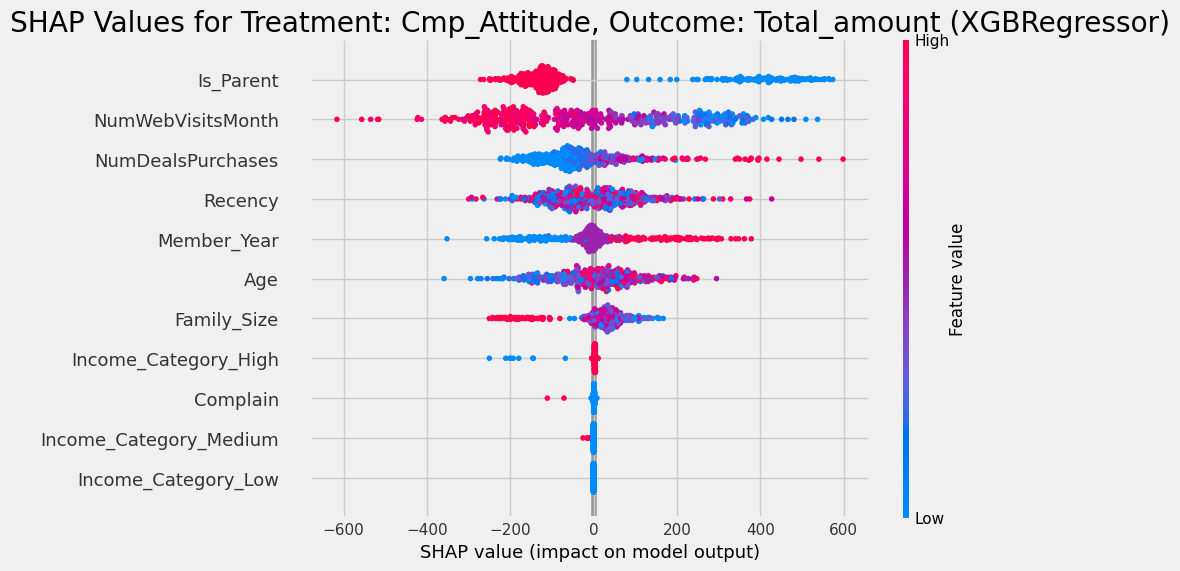

[23:37:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


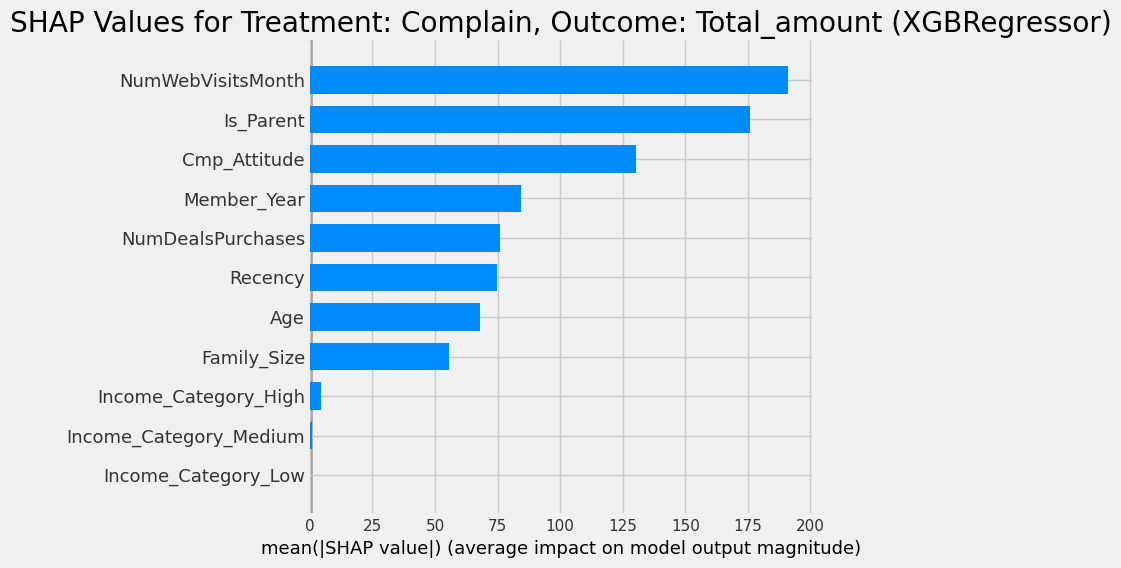

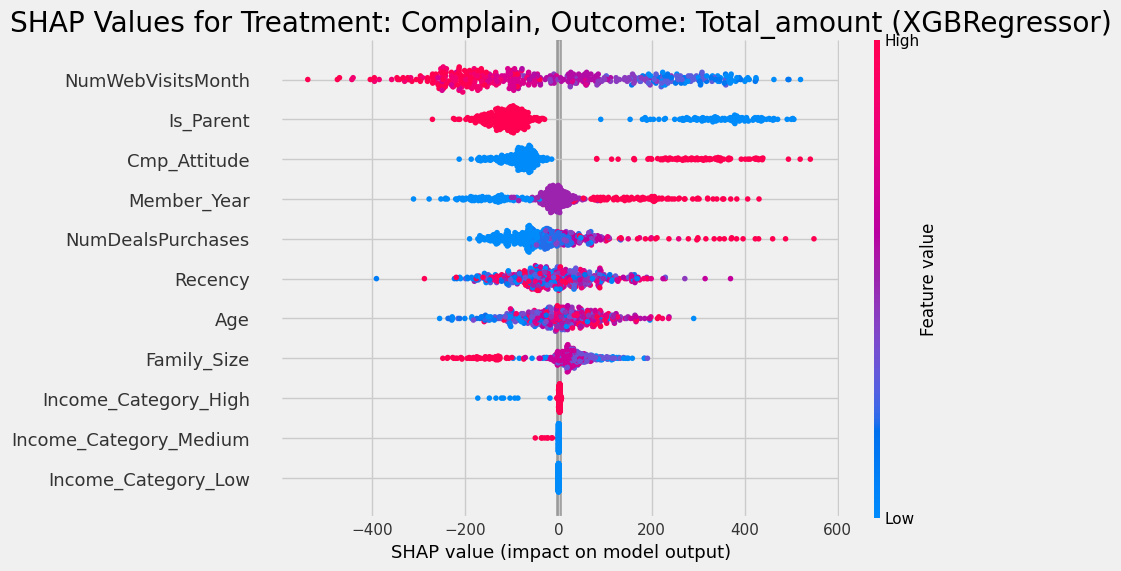

,Outcome,Treatment,Model Type,ATE,RMSE
0,Total_amount,Income_Category_High,XGBRegressor,0.984333,857.475652
1,Total_amount,Is_Parent,XGBRegressor,0.715721,857.820259
2,Total_amount,Cmp_Attitude,XGBRegressor,0.238322,857.934793
3,Total_amount,Complain,XGBRegressor,0.013449,858.196545


In [124]:
# Define treatments and covariates
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
                   'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
                   'Member_Year', 'Total_amount', 'Total_purchase',
                   'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']

# Run causal inference pipeline
results_df = causal_inference_pipeline(df, covariates_list, treatments)
results_df